# Introduction and background
 
 **Disclaimer:** This tutorial does not use `qgrad`. The intention is to show follow this tutorial with another one _using_ `qgrad` to show to how easier things are with qgrad.
 
 In this tutorial, we aim to learn unitary matrices using gradient descent. The tutorial reproduces [Lloyd et al.](https://arxiv.org/abs/1901.03431) and [Bobak et al.](https://arxiv.org/abs/2001.11897), and follows similar formalism as introduced in the two papers.
 
 For a target unitary matrix, $U$, we intend to find optimal parameter vectors for the parameterized unitary $U(\vec{t}, \vec{\tau})$, such that $U(\vec{t}, \vec{\tau})$ approximates $U$ as closely as possible. Here, 
 
 \begin{equation}\label{decomp}
     U(\vec{t}, \vec{\tau}) = e^{-iB\tau_{N}}e^{-iAt_{N}} ... e^{-iB\tau_{1}}e^{-iAt_{1}}
 \end{equation}
 
where $\vec{t}$ and $\vec{\tau}$ are paramter vectors of size $N$.

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import tenpy 
from qutip import fidelity, Qobj, rand_ket
from scipy.stats import unitary_group
from scipy.linalg import expm

In [35]:
def make_dataset(m, d):
    r"""Prepares a dataset of input and output kets to be used for training.
    
    Args:
    ----
        m (int): Number of data points, 80% of which would be used for training
        d (int): Dimension of a (square) unitary matrix to be approximated
    
    Returns:
    --------
        data_points (tuple): tuple of lists containing (numpy arrays of) input and output kets respectively.
    """
    ket_input = []
    ket_output = [] 
    for i in range(m):
        ket_input.append(rand_ket(d, seed=300).full())
        ket_output.append(np.matmul(tar_unitr, ket_input[i]))  #Output data -- action of unitary on a ket states
    
    return (ket_input, ket_output)

m = 100 # number of training data points
train_len = int(m * 0.8)
d = 2 #dimension of unitary 
N = 4 #size of parameter vectors tau and t
tar_unitr = unitary_group.rvs(d)  # Fixed random d-dimensional target unitary matrix that we want to learn                                          
res = make_dataset(m, d)
ket_input, ket_output = res[0], res[1]

# Recipe for making $U(\vec{t}, \vec{\tau})$
 
 We make $U(\vec{t}, \vec{\tau})$ by repeated application of $e^{-iB\tau_{k}}e^{-iAt_{k}}$ at k-th step. We multiply $e^{-iB\tau_{k}}e^{-iAt_{k}}$ in a [QAOA](https://arxiv.org/abs/1411.4028) like fashion $N$ times, where N is the dimension of $\vec{t}$ and $\vec{\tau}$. Higher N $\rightarrow$ better approximation.
 
[Lloyd et al.](https://arxiv.org/abs/1901.03431) and [Bobak et al.](https://arxiv.org/abs/2001.11897), matrices $A$ and $B$ are chosen from a Gaussian Unitary Ensemble (GUE). We use `tenpy` to sample $A$ and $B$ from GUE.


In [36]:
A = tenpy.linalg.random_matrix.GUE((d,d)) # tenpy for sampling A and B from GUE
B = tenpy.linalg.random_matrix.GUE((d,d)) 

In [37]:
def make_unitary(N, params):
    r"""Returns a paramterized unitary matrix.
    
    : math:: \begin{equation}\label{decomp}
                U(\vec{t}, \vec{\tau}) = e^{-iB\tau_{N}}e^{-iAt_{N}} ... e^{-iB\tau_{1}}e^{-iAt_{1}}
             \end{equation}
             
    Args:
    ----
        N (int): Size of the parameter vectors, :math:`\tau` and :math:`\t`
        params (:obj:`np.ndarray`): parameter vector of size :math:`2 * N` where the first half parameters are  
                                   :math:`\vec{t}` params and the second half encodes \vec{\tau}) parameters.
                                   
    Returns:
        unitary (:obj:`np.ndarray`): numpy array representation of paramterized unitary matrix 
    """
    unitary = np.eye(d)
    for i in range (N): 
        unitary = np.matmul(np.matmul(expm(-1j*B*params[i+N][0]),expm(-1j*A*params[i][0])), unitary)
    
    return unitary 


# Criteria for learnability -- the cost function
 The cost function formulation of gradient descent learning is defined by the authors is as follows:
 
 $\begin{equation} \label{err_ps}
         E = 1 - (\frac{1}{M})\sum_{l} \langle \psi_{l}|U^{\dagger} U(\vec{t},\vec{\tau})|\psi_{l}\rangle
 \end{equation}$, 
 
 where $ |\psi_{l}>$ is the training (or testing) data points -- in this case, kets. We implement the same formulation below.


In [38]:
def cost(params, inputs, outputs):
    r"""Calculates the cost/error on the whole training datat set.
    
    Args:
    ----
        params: parameters :math:`\t` and :math:`\tau` in :math:`U^{\dagger} U(\vec{t},\vec{\tau})`
        inputs: input kets :math:`|\psi_{l}>` in the dataset 
        outputs: output kets :math:`U(\vec{t}, \vec{\tau})*|ket\_input>` in the dataset
    
    Returns:
    -------
        cost (float): cost (evaluated on the enitre dataset) of parametrizing 
                     :math:`\tau` in :math:`U^{\dagger} U(\vec{t},\vec{\tau})` with `params`                  
    """
    loss = 0.0
    for k in range(train_len): 
        pred = np.matmul(make_unitary(N, params), inputs[k]) #prediction wth parametrized unitary
        loss += np.absolute(np.real(np.matmul(outputs[k].conjugate().T, pred)))
        # TODO check real and abs in loss above since   
        # it's not in the original paper
    return 1 - (1 / train_len) * loss 

# Differentation of the cost function
 
 Gradient descent is a first order method, so one definitely needs to take the derivative of the cost function. Analytically, the gradient of above error term, or the cost function, is 
 
 $ 
 \begin{equation}
     \frac{\partial}{\partial \tau_{k}}E(\vec{t},\vec{\tau}) = -\frac{1}{M}\sum_{l} \langle \psi_{l}|U^{\dagger}[e^{-iAt_{N}}e^{-iB\tau_{N}} ... (-iB)e^{-iB\tau_{k}}e^{-iAt_{k}} ... e^{-iB\tau_{1}}e^{-iAt_{1}}]|\psi_{l}\rangle
 \end{equation}
 $
 

In [39]:
def der_cost(params, inputs, outputs):
    """ Calculates the numerical derivative of the cost w.r.t to each parameter"""
    grad = [] 
    for i in range(params.shape[0]):
        eps = np.zeros((params.shape[0], 1))
        eps[i] = eps[i] + 1e-3
        grad.append((cost(params+eps, inputs, outputs)
                     - cost(params, inputs, outputs)) / 1e-3)
    return np.array(grad).reshape(params.shape[0], 1)

# Performance Metric -- fidelity
 
While cost is a valid metric to judge the learnability. We introduce another (commonly used) metric, fidelty between the predicted and the output (label) states as a sanity check.

In [40]:
def test_score(params, x, y):
    """Calculates the avergage fidelity between the predicted and output kets for a given 
       on the whole dataset.
       
       Args:
       ----
           params: parameters :math:`\t` and :math:`\tau` in :math:`U^{\dagger} U(\vec{t},\vec{\tau})`
           x: input kets :math:`|\psi_{l}>` in the dataset 
           y: output kets :math:`U(\vec{t}, \vec{\tau})*|ket\_input>` in the dataset
           
       Returns:
       -------
           fidel (float): fidelity between :math:`U(\vec{t}, \vec{\tau})*|ket\_input>` and
                          the output (label) kets for parameters :math:`\vec{t}, \vec{\tau}`
                          averaged over the entire training set.
       """
    fidel = 0
    for i in range(train_len):
        pred = np.matmul(make_unitary(N, params), x[i])
        step_fidel = fidelity(Qobj(pred), Qobj(y[i]))
        fidel += step_fidel
        
        
    return fidel / train_len

# Gradient Descent Implementation
 
 We implement gradient descent based on 
 
 $\begin{equation} \label{gd}
     t_{k} = t_{k} - \alpha \frac{\partial}{\partial t_{k}}E(\vec{t},\vec{\tau})
 \end{equation}$
  for a single parameter $t_{k}$, where $\alpha$ is the learning rate. 

In [41]:
epochs = 40
alpha = 1e-1
loss_hist = []
fidel_hist = []
params_hist = []
np.random.seed(340)
weights = np.random.rand(2 * N, 1)

for epoch in range(epochs):
    weights = weights - alpha * (der_cost(weights, ket_input, ket_output))
    loss = cost(weights, ket_input, ket_output).item() # convert numpy (1,1) array to native python float
    avg_fidel = test_score(weights, ket_input, ket_output)
    progress = [epoch+1, loss, avg_fidel]
    loss_hist.append(loss)
    fidel_hist.append(avg_fidel)
    params_hist.append(weights)
    if ((epoch) % 10 == 9):
        print("Epoch: {:2f} | Loss: {:3f} | Fidelity: {:3f}".format(*np.asarray(progress)))
    
opt_params = weights

Epoch: 10.000000 | Loss: 0.087398 | Fidelity: 0.913605
Epoch: 20.000000 | Loss: 0.010100 | Fidelity: 0.990082
Epoch: 30.000000 | Loss: 0.001065 | Fidelity: 0.998963
Epoch: 40.000000 | Loss: 0.000109 | Fidelity: 0.999895


# Efficient reconstruction of the target unitary
The papers claim that if the dimension, N, of the parameters is of order $O(d^{2})$, where $d$ is the dimension of the unitary, then $U(\vec{t},\vec{\tau})$ is constructed _efficiently_. We verify this claim with $d = 2$ and $N = 5$. Fidelity can be further improved, and loss reduced, if training is carried on for a greater number of epochs and the learning rate $\alpha$ is tuned further.

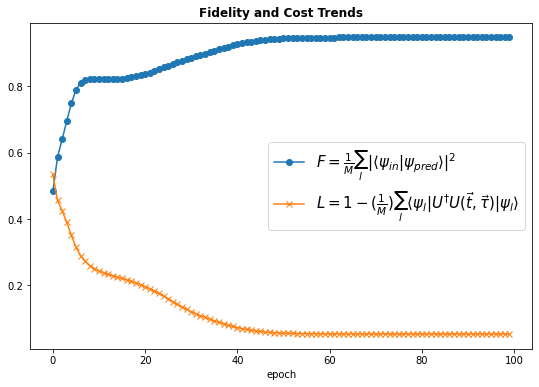

In [13]:
plt.figure(figsize=(9, 6))
plt.plot(range(epochs), np.asarray(fidel_hist).ravel(), marker = 'o', 
         label=r"$F = \frac{1}{M}\sum_{l}| \langle \psi_{in} | \psi_{pred} \rangle |^2$")
plt.plot( range(epochs), np.asarray(loss_hist).ravel(), marker = 'x',
        label=r"$L = 1 - (\frac{1}{M})\sum_{l}\langle \psi_{l} | U ^{\dagger} U(\vec{t},\vec{\tau}) | \psi_{l} \rangle$")
plt.title("Fidelity and Cost Trends", fontweight = "bold")
plt.legend(["Fidelity","Loss"])
plt.xlabel("epoch")
plt.legend(loc=0, prop = {'size': 15})

 We would expect the average fidelity, $F$, to increase since we defined fidelity to be between $U(\vec{t}, \vec{\tau})*|ket\_input>$ and the output (label) kets for parameters $\vec{t}, \vec{\tau}$ averaged over the entire training set. The expected pattern is reflected in the training graph above with the loss, $L$, is the cost that we aim to minimize decreasing progressively. Slight dips in the graph maybe due to non-convex landscape of the cost function as authors report in the paper.

# Testing on the unseen kets
 
We reserved $20 \%$ of the kets for testing. Another metric we can use to evaluate learnability is to compare the fidelities of the kets $|\psi_{l}>$ acted on by the target unitary, U,  like $U |\psi_{l}>$ with the fidelity of the ket obtained by acting $U(\vec{t}, \vec{\tau})$ on the same $|\psi_{l}>$ like $U(\vec{t}, \vec{\tau})*|\psi_{l}>$, where $|\psi_{l}>$ is a ket in the test data
 

In [14]:
opt_unitary = make_unitary(N, opt_params)
fidel = []
for i in range(train_len, m): # unseen data
    pred = np.matmul(opt_unitary, ket_input[i])
    fidel.append(fidelity(Qobj(pred), Qobj(ket_output[i])))

Text(0, 0.5, 'Fidelity between output ket and evolved ket')

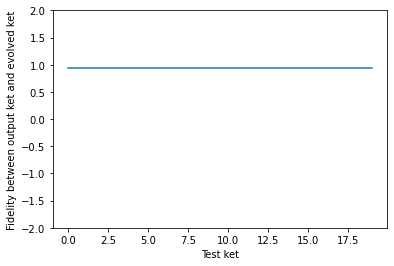

In [15]:
plt.plot(range(len(fidel)), fidel)
plt.ylim(-2, 2)
plt.xlabel("Test ket")
plt.ylabel("Fidelity between output ket and evolved ket")

# Conclusion
 
The learned unitary matrix, $U(\vec{t}, \vec{\tau})$, almost perfectly reconstructs the target unitary, $U$, in the sense that the way $U$ evolves a ket $|\psi_{l}>$, $U(\vec{t}, \vec{\tau})$ also evovles $|\psi_{l}>$ in about the same way. This can be seen in the graph above that the fidelities between states evolved by $U(\vec{t}, \vec{\tau})$ and $U$ are almost perfect. 
